# Fresnel's Equations
The prupose of this code is to establish a baseline using theory and some measured data, and compare it to simulation results to ensure optical properties are properly set. This will be done by plotting fresnel's equations as a function of incident angle and refractive index, which is a function of wavelength.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2

In [4]:
data_frame = pd.read_csv('csv/Plastic (Acrylic) - Sultanova.csv')
scale_factor = 1000 # micrometers to nanometers
wavelengths = scale_factor * data_frame.iloc[:, 0].values
refraction_indices = data_frame.iloc[:, 1].values



To fit the refractive index data, we can use the Sellmeier equation (https://en.wikipedia.org/wiki/Sellmeier_equation) which is an empirical relationship between the refractive index and wavelength for transparent media. It is given by
$$ n^2(\lambda) = 1 + \sum_i \frac{\lambda^2A_i}{\lambda^2 - B_i}$$
where $A_i$ and $B_i$ are Sellmeier coefficients determined by plotting the data.

In [5]:

def n2(wavelength, A, B, C, D, E, F, G, H, I, J):
    return np.sqrt(1 + (A * wavelength ** 2) / (wavelength **2 - B) + (C * wavelength ** 2) / (wavelength **2 - D) + (E * wavelength ** 2) / (wavelength **2 - F) + (G * wavelength ** 2) / (wavelength **2 - H) + (I * wavelength ** 2) / (wavelength **2 - J))

# Define the significance level (want 1%)
significance_level = 0.01

# Define the degrees of freedom
degrees_of_freedom = len(wavelengths) - 1

# Find the critical value
critical_value = chi2.ppf(1 - significance_level, degrees_of_freedom)

# Initial guess for the parameters
initial_guess = [0, 1000, 0, 1000, 0, 1000, 0, 1000, 0, 1000]

# Perform curve fitting
fit_params, _ = curve_fit(n2, wavelengths, refraction_indices, p0=initial_guess, maxfev=7000000)

# Retrieve the fitted parameters
A_fit, B_fit, C_fit, D_fit, E_fit, F_fit, G_fit, H_fit, I_fit, J_fit = fit_params

# Generate data for the fitted curve
wavelengths_fit = np.linspace(wavelengths.min(), wavelengths.max(), 1000)
refractive_index_fit = n2(wavelengths_fit, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit, G_fit, H_fit, I_fit, J_fit)

# Calculate the residuals
residuals = refraction_indices - n2(wavelengths, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit, G_fit, H_fit, I_fit, J_fit)

# Calculate the chi-squared value
chi_squared = np.sum(residuals ** 2)

print(f"Chi squared: {chi_squared}\nCritical chi squared: {critical_value}")


Chi squared: 5.88440483024478e-11
Critical chi squared: 135.80672317102676


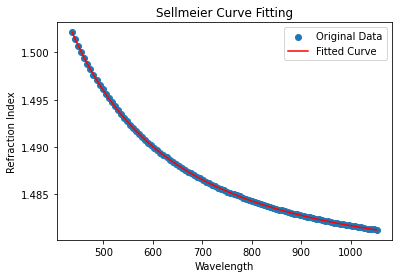

In [6]:
# Plot the original data and the fitted curve
plt.scatter(wavelengths, refraction_indices, label='Original Data')
plt.plot(wavelengths_fit, refractive_index_fit, color='red', label='Fitted Curve')
plt.xlabel('Wavelength')
plt.ylabel('Refraction Index')
plt.legend()
plt.title('Sellmeier Curve Fitting')

# Show the plot
plt.show()

Armed with a functional form for the refractive index, we can determine the reflectivity and transmittance using Fresnel's equations (https://en.wikipedia.org/wiki/Fresnel_equations). To simplify things, tests in chroma will be done by shining light from a vacuum onto a material (meaning $n_1$ = 1). This reduces fresnel's equations to
$$R_s = \left| \frac{\cos{\theta_i} - n(\lambda)\cos{\theta_t}}{\cos{\theta_i} + n(\lambda)\cos{\theta_t}} \right|^2$$
and
$$R_p = \left| \frac{n(\lambda)\cos{\theta_i} - \cos{\theta_t}}{n(\lambda)\cos{\theta_i} + \cos{\theta_t}} \right|^2$$
where, by Snell's law
$$\theta_t = \arcsin \left(\frac{\sin{\theta_i}}{n(\lambda)} \right) $$

and $T = 1 - R$ for both S and P polarizations.

In [7]:
n1 = 1  # air
incident_angle = np.linspace(0, np.pi / 2, 1000) # 0 to 90 degrees
transmitted_angle = np.arcsin(np.sin(incident_angle) / refractive_index_fit)

# S polarization
def R_s(incident_angle, n2):
    return np.abs((np.cos(incident_angle) - n2 * np.cos(transmitted_angle)) / (np.cos(incident_angle) + n2 * np.cos(transmitted_angle))) ** 2

def T_s(incident_angle, n2):
    return 1 - R_s(incident_angle, n2)

# P polarization
def R_p(incident_angle, n2):
    return np.abs((n2 * np.cos(incident_angle) - np.cos(transmitted_angle)) / (n2 * np.cos(incident_angle) + np.cos(transmitted_angle))) ** 2

def T_p(incident_angle, n2):
    return 1 - R_p(incident_angle, n2)

incident_angle_mesh, n2_mesh = np.meshgrid(incident_angle, refractive_index_fit)

reflection_coefficient_s = R_s(incident_angle_mesh, n2_mesh)
transmission_coefficient_s = T_s(incident_angle_mesh, n2_mesh)

reflection_coefficient_p = R_p(incident_angle_mesh, n2_mesh)
transmission_coefficient_p = T_p(incident_angle_mesh, n2_mesh)


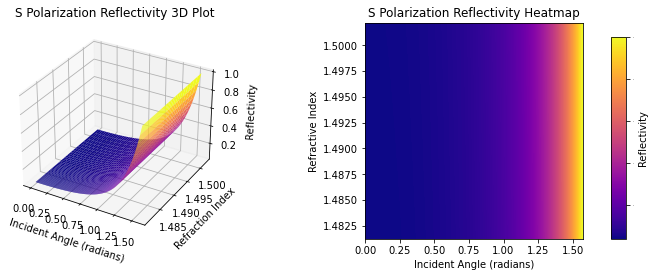

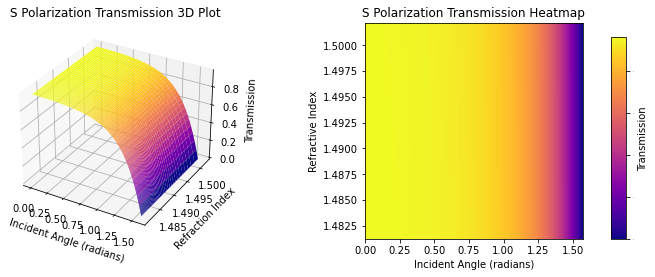

In [8]:


# Create 3D plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, n2_mesh, reflection_coefficient_s, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refraction Index')
ax.set_zlabel('Reflectivity')
ax.set_title('S Polarization Reflectivity 3D Plot')

# Create heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, n2_mesh, reflection_coefficient_s, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_title('S Polarization Reflectivity Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Reflectivity')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()



# Create 3D plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, n2_mesh, transmission_coefficient_s, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refraction Index')
ax.set_zlabel('Transmission')
ax.set_title('S Polarization Transmission 3D Plot')

# Create heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, n2_mesh, transmission_coefficient_s, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_title('S Polarization Transmission Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Transmission')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()

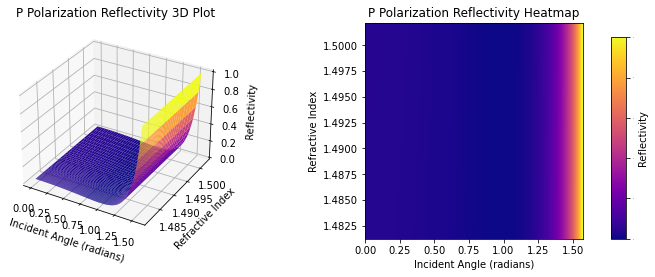

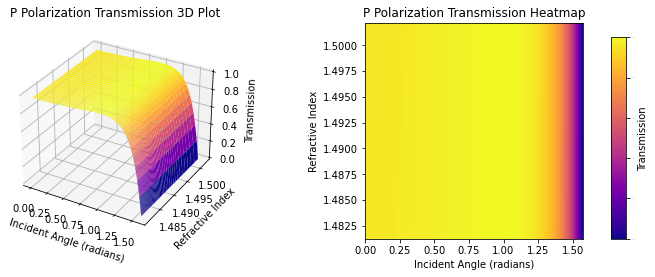

In [9]:


# Create 3D plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, n2_mesh, reflection_coefficient_p, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_zlabel('Reflectivity')
ax.set_title('P Polarization Reflectivity 3D Plot')

# Create heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, n2_mesh, reflection_coefficient_p, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_title('P Polarization Reflectivity Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Reflectivity')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()



# Create 3D plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(incident_angle_mesh, n2_mesh, transmission_coefficient_p, cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_zlabel('Transmission')
ax.set_title('P Polarization Transmission 3D Plot')

# Create heatmap
ax = fig.add_subplot(122)
heatmap = ax.pcolormesh(incident_angle_mesh, n2_mesh, transmission_coefficient_p, shading='auto', cmap='plasma')
ax.set_xlabel('Incident Angle (radians)')
ax.set_ylabel('Refractive Index')
ax.set_title('P Polarization Transmission Heatmap')

# Add colorbar for the heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax, label='Transmission')

# Adjust subplot spacing
fig.subplots_adjust(left=0.08, right=0.88, top=0.9, bottom=0.15, wspace=0.65)

# Adjust the font size of the axis numbers
plt.tick_params(axis='both', which='major', labelsize=0.5)

# Show the plots
plt.show()